# Using CLIP to query an image dataset via text

This notebook describes how to text query an image dataset using pretrained and fine-tuned OpenAI's multi-modal CLIP model.


## Notebook setup


In [46]:
import clip
import datetime
import math
import os
import torch
import tqdm
import dtlpy as dl
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import umap.umap_ as umap

from PIL import Image
from pathlib import Path
from sklearn.metrics.pairwise import cosine_similarity

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split

from bokeh.plotting import figure, show, output_file
from bokeh.models import HoverTool, ColumnDataSource, CategoricalColorMapper
from bokeh.palettes import Viridis

## Generate descriptions for images from labels

A description is generated for the dataset based on the objects detected in the image, and will be printed to help assess model efficacy.

In [47]:
# create descriptions for each image from its annotations
import dtlpy as dl

def create_descrip(labels: list):
    description = "a photo"
    if len(labels) != 0:
        description += " of a "
        for i, label in enumerate(labels):
            if i < len(labels) - 1:
                description += f"{label}, "
            else:
                description += f"and {label}."
    return description

# setup dtlpy
dl.setenv('prod')
if dl.token_expired():
    dl.login()

dl_dataset = dl.datasets.get(dataset_id='64c27e74615b1c5d7d576776')

# for training, adding annotations as descriptions
all_labels = dl_dataset.labels
new_label_names = [label.tag for label in all_labels]

# create text descriptions from labels
items = list(dl_dataset.items.list().all())
item_labels_lookup = {}
pbar = tqdm.tqdm(total=len(items))
for i, item in enumerate(items):
    item_name = item.name
    annotations = item.annotations.list()
    item_labels = []
    for annotation in annotations:
        item_labels.append(str(annotation.label).split(".")[-1])
    item_labels_lookup[item_name] = item_labels
    pbar.update()

Iterate Entity: 100%|████████████████████████████| 1500/1500 [00:01<00:00, 856.17it/s]


100%|█████████████████████████████████████████████| 1500/1500 [03:11<00:00,  8.81it/s]

## Load model, images

Images are directly loaded from an file directory, and then compiled as Image objects for later embedding or training.
Check that every filepath is an image, and open and add to the images list for embedding.

In [48]:
# save_dir = r"output"
timestamp = datetime.datetime.now().strftime('%Y%m%d_%H%M')
save_dir = rf'C:\Users\Yaya Tang\PycharmProjects\clip-smart-search\output\{timestamp}'
os.makedirs(save_dir, exist_ok=True)

# load saved, trained model
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device)

In [49]:
def is_image_file(filename):
    img_extensions = ['.jpg', '.jpeg', '.png', '.bmp', '.gif', '.tiff']
    return any(filename.lower().endswith(ext) for ext in img_extensions)

# load images to embed and query
img_dir = Path(r"C:\Users\Yaya Tang\Documents\DATASETS\TACO dataloop\items\raw")
orig_img_paths = [str(img_path) for img_path in img_dir.glob("*") if is_image_file(str(img_path))]
img_paths = orig_img_paths.copy()

# prepare images
images_np = []
pbar = tqdm.tqdm(total=len(img_paths))
for img_path in img_paths:
    img_np = Image.open(img_path).convert("RGB")
    images_np.append(preprocess(img_np))
    pbar.set_description(f"Processing {img_path}...")
    pbar.update()
print(len(img_paths))


100%|█████████████████████████████████████████████| 1500/1500 [03:13<00:00,  7.77it/s]

Processing C:\Users\Yaya Tang\Documents\DATASETS\TACO dataloop\items\raw\000000.jpg...
Processing C:\Users\Yaya Tang\Documents\DATASETS\TACO dataloop\items\raw\000001.jpg...
Processing C:\Users\Yaya Tang\Documents\DATASETS\TACO dataloop\items\raw\000001.jpg...
Processing C:\Users\Yaya Tang\Documents\DATASETS\TACO dataloop\items\raw\000002.jpg...
Processing C:\Users\Yaya Tang\Documents\DATASETS\TACO dataloop\items\raw\000003.jpg...
Processing C:\Users\Yaya Tang\Documents\DATASETS\TACO dataloop\items\raw\000003.jpg...
Processing C:\Users\Yaya Tang\Documents\DATASETS\TACO dataloop\items\raw\000004.jpg...
Processing C:\Users\Yaya Tang\Documents\DATASETS\TACO dataloop\items\raw\000005.jpg...
Processing C:\Users\Yaya Tang\Documents\DATASETS\TACO dataloop\items\raw\000005.jpg...
Processing C:\Users\Yaya Tang\Documents\DATASETS\TACO dataloop\items\raw\000006.jpg...
Processing C:\Users\Yaya Tang\Documents\D

1499


## Create image embeddings

Use the loaded CLIP model to create a feature set.

In [50]:
image_input = torch.tensor(np.stack(images_np)).to(device)
with torch.no_grad():
    image_features = model.encode_image(image_input)

image_features /= image_features.norm(dim=-1, keepdim=True)


Processing C:\Users\Yaya Tang\Documents\DATASETS\TACO dataloop\items\raw\IMG_5068.JPG.

## Query images with pretrained CLIP

Enter the query to create its embedding so we can find the nearest images in the feature space.

In [51]:
# create query feature
QUERY_STRING = "cigarettes on the sidewalk"
query_keyword = "cigarette"
NUM_RESULTS = 20

text_tokens = clip.tokenize([QUERY_STRING]).to(device)
with torch.no_grad():
    text_features = model.encode_text(text_tokens)
text_features /= text_features.norm(dim=-1, keepdim=True)

## Get the K nearest images to the query

In [52]:
# get top results
results = cosine_similarity(text_features.cpu().numpy(), image_features.cpu().numpy())

results_dict = {'name': [], 'prob': [], 'filepath': []}

pbar = tqdm.tqdm(total=len(img_paths))
for i, img_path in enumerate(img_paths):
    results_dict['name'].append(Path(img_path).name)
    results_dict['prob'].append(results[0][i])
    results_dict['filepath'].append(img_path)
    results_dict.update()
    pbar.update()

results_df = pd.DataFrame(results_dict)
results_df.sort_values(by=['prob'], ascending=False, inplace=True)

results_df = results_df.iloc[:NUM_RESULTS][['name', 'prob', 'filepath']]
print(results_df[['name', 'prob']])


results_with_labels = results_df[['name', 'prob']]
results_with_labels['labels'] = [item_labels_lookup[name] for name in results_df['name']]
results_with_labels['has_keyword'] = [1 if query_keyword in [item.lower() for item in result] else 0 for result in results_with_labels['labels']]
results_with_labels.to_csv(Path(save_dir, f'pretrained_results_{timestamp}.csv'))

# show the number of images with labels that include the keyword
num_hits = sum(results_with_labels['has_keyword'])
print(f'Number of images that have the keyword in the labels: {num_hits}')

Processing C:\Users\Yaya Tang\Documents\DATASETS\TACO dataloop\items\raw\IMG_5068.JPG.

                      name      prob
1404          IMG_4855.JPG  0.341405
532   batch_14__000032.jpg  0.334389
1082   batch_6__000003.JPG  0.328373
596   batch_14__000096.jpg  0.326343
1327   batch_8__000025.jpg  0.325796
651   batch_15__000051.jpg  0.324077
1383   batch_8__000081.jpg  0.321512
623   batch_15__000023.jpg  0.319483
1442          IMG_4928.JPG  0.318599
1031   batch_5__000069.JPG  0.318363
652   batch_15__000052.jpg  0.317512
1240   batch_7__000077.JPG  0.312344
1331   batch_8__000029.jpg  0.312260
1362   batch_8__000060.jpg  0.312130
972    batch_5__000006.JPG  0.311862
1313   batch_8__000011.jpg  0.311087
1208   batch_7__000039.JPG  0.309970
136   batch_10__000036.jpg  0.309612
1207   batch_7__000038.JPG  0.309535
966    batch_4__000098.JPG  0.309362
Number of images that have the keyword in the labels: 9


## Plot the returned images from query

Show the top N most similar images for this text/query (user defined above)

In [53]:
# create model text features
model = model.eval()

text_tokens = clip.tokenize([QUERY_STRING]).to(device)
with torch.no_grad():
    text_features = model.encode_text(text_tokens)
text_features /= text_features.norm(dim=-1, keepdim=True)

In [54]:
# get top results
result = cosine_similarity(text_features.cpu().numpy(), image_features.cpu().numpy())

In [55]:
# convert to df
results_dict = {'name': [], 'prob': [], 'filepath': []}

pbar = tqdm.tqdm(total=len(img_paths))
for i, img_path in enumerate(img_paths):
    results_dict['name'].append(Path(img_path).name)
    results_dict['prob'].append(result[0][i])
    results_dict['filepath'].append(img_path)
    results_dict.update()
    pbar.update()

results_df = pd.DataFrame(results_dict)
results_df.sort_values(by=['prob'], ascending=False, inplace=True)

results_df = results_df.iloc[:NUM_RESULTS][['name', 'prob', 'filepath']]

results_with_labels = results_df[['name', 'prob']]
results_with_labels['labels'] = [item_labels_lookup[name] for name in results_df['name']]
results_with_labels['has_keyword'] = [1 if query_keyword in [item.lower() for item in result] else 0 for result in results_with_labels['labels']]

results_with_labels.to_csv(Path(save_dir, f'pretrained_results_{timestamp}.csv'))
print(results_with_labels[['name', 'prob']]) #, 'labels']])

# show the number of images with labels that include the keyword
num_hits = sum(results_with_labels['has_keyword'])
print(f'Number of images that have the keyword in the labels: {num_hits}')


100%|██████████████████████████████████████████| 1499/1499 [00:00<00:00, 11911.19it/s]

                      name      prob
1404          IMG_4855.JPG  0.341405
532   batch_14__000032.jpg  0.334389
1082   batch_6__000003.JPG  0.328373
596   batch_14__000096.jpg  0.326343
1327   batch_8__000025.jpg  0.325796
651   batch_15__000051.jpg  0.324077
1383   batch_8__000081.jpg  0.321512
623   batch_15__000023.jpg  0.319483
1442          IMG_4928.JPG  0.318599
1031   batch_5__000069.JPG  0.318363
652   batch_15__000052.jpg  0.317512
1240   batch_7__000077.JPG  0.312344
1331   batch_8__000029.jpg  0.312260
1362   batch_8__000060.jpg  0.312130
972    batch_5__000006.JPG  0.311862
1313   batch_8__000011.jpg  0.311087
1208   batch_7__000039.JPG  0.309970
136   batch_10__000036.jpg  0.309612
1207   batch_7__000038.JPG  0.309535
966    batch_4__000098.JPG  0.309362
Number of images that have the keyword in the labels: 9


Saved query results to C:\Users\Yaya Tang\PycharmProjects\clip-smart-search\output\20230810_1200\clip_query_results_PRETRAINED_20230810_1200.png


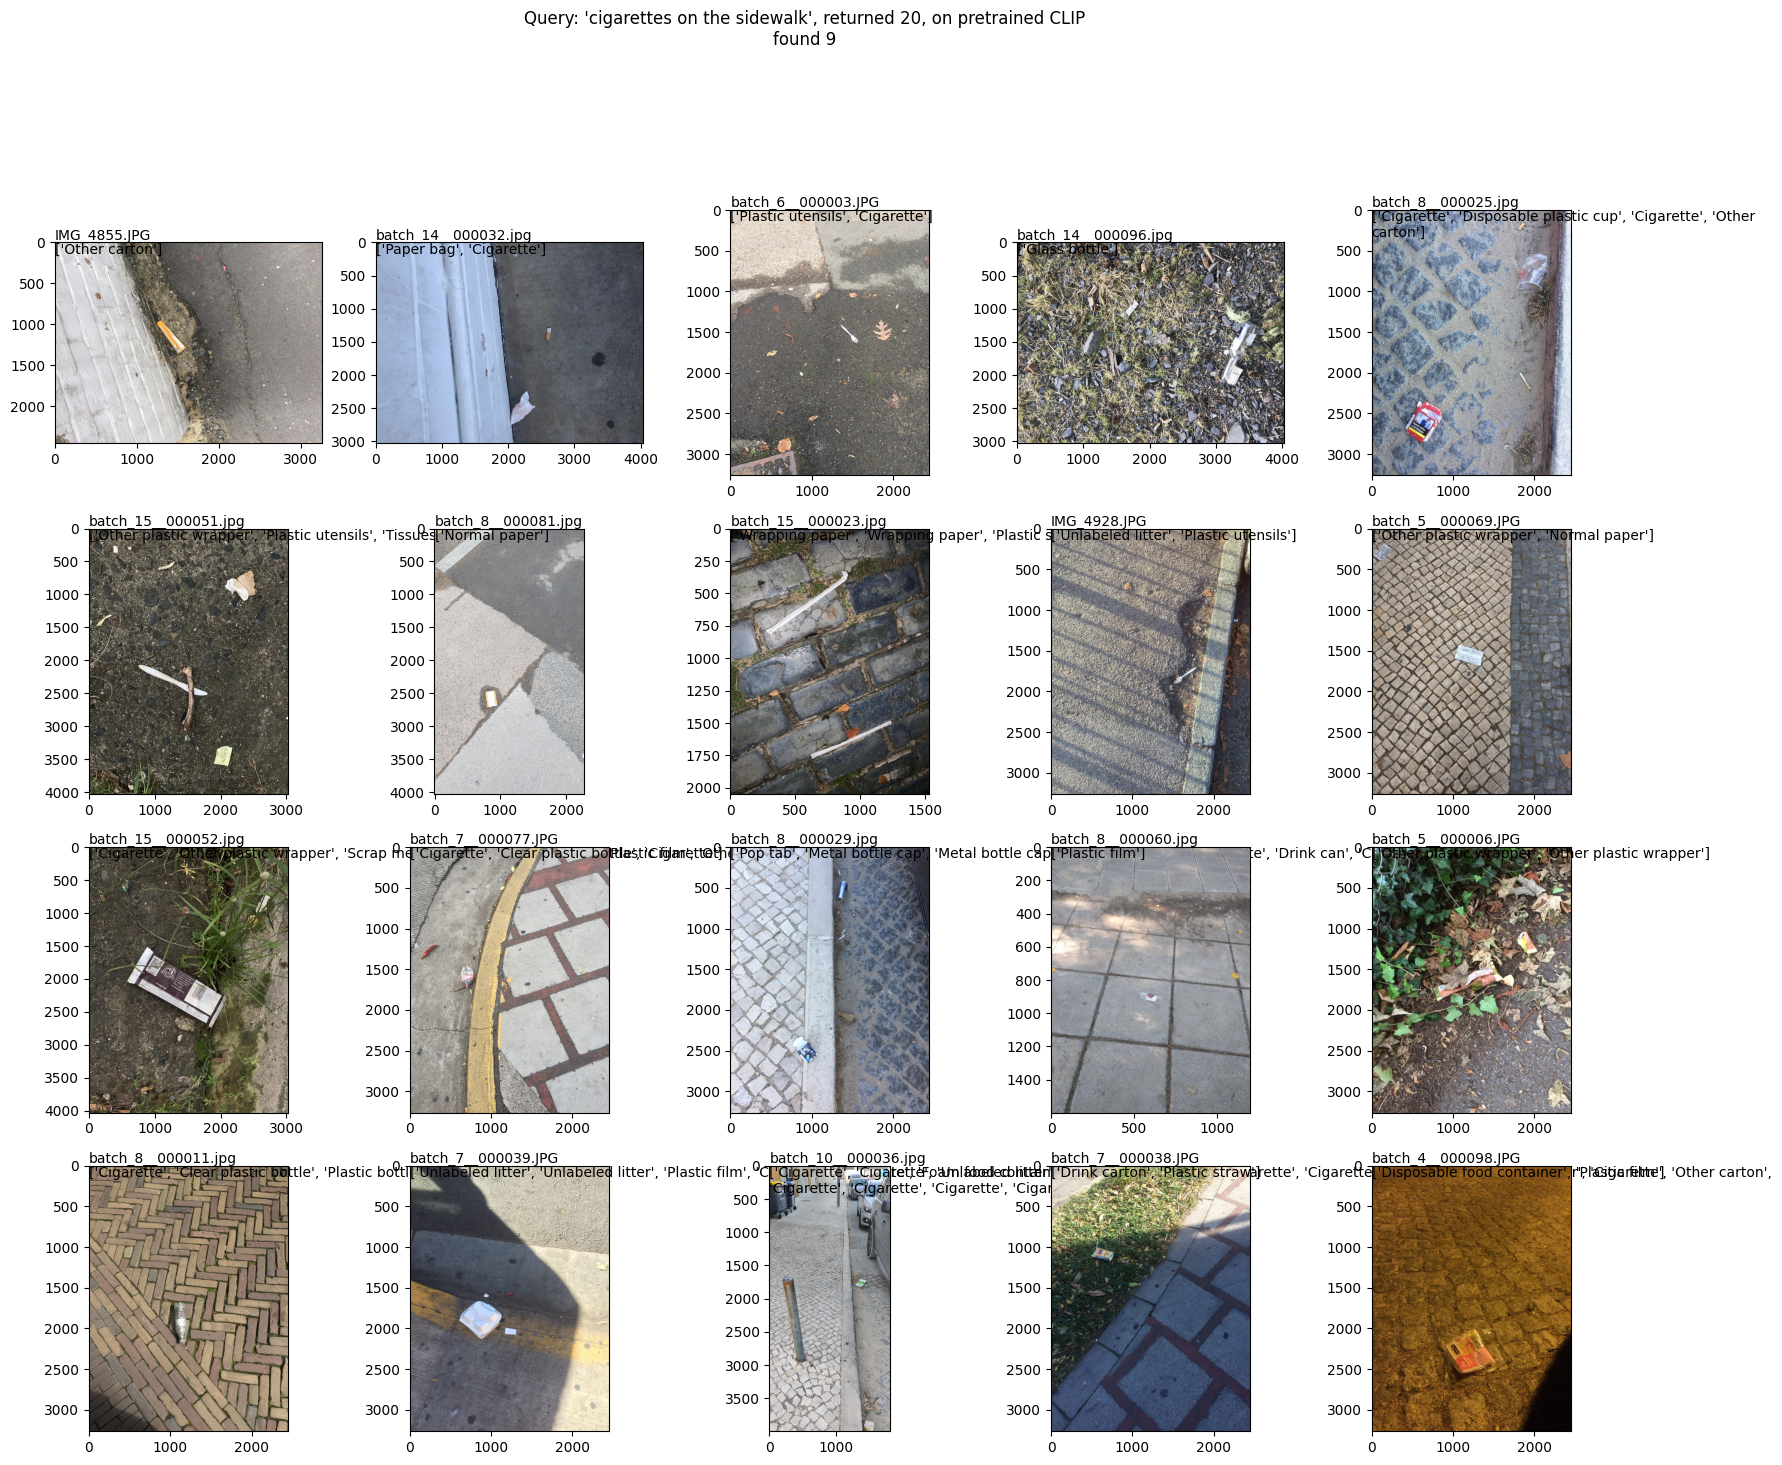

In [56]:
# plot returned images on a grid
num_grid = math.isqrt(NUM_RESULTS)
subplot_dims = num_grid + 1 if num_grid ** 2 < NUM_RESULTS else num_grid

plt.figure(figsize=(20, 20))
plt.tight_layout()
for i, img_path in enumerate(results_df['filepath'].iloc[:NUM_RESULTS]):
    plt.subplot(subplot_dims, subplot_dims, i + 1)
    image = Image.open(img_path).convert("RGB")
    plt.text(0,-1, f'{Path(img_path).name}', verticalalignment="bottom")
    plt.text(0,0, f'{item_labels_lookup[Path(img_path).name]}', verticalalignment="top", wrap=True)
    plt.imshow(image)

plt.suptitle(f"Query: '{QUERY_STRING}', returned {len(results_df)}, on pretrained CLIP\nfound {num_hits}")

plot_filename = f"clip_query_results_PRETRAINED_{timestamp}.png"
save_path = os.path.join(save_dir, plot_filename)
plt.savefig(save_path, dpi=800)
print(f'Saved query results to {save_path}')

## Visualize: Dimensionality reduction with UMAP 

For UMAP dimension reduction, we can take the image features (n_images, 512) to (n_images, 2)


In [57]:
# concatenate both image + query features and reduce with UMAP

all_features = torch.cat((image_features, text_features), 0)
reducer = umap.UMAP(random_state=42, metric='cosine')
embedding = reducer.fit_transform(all_features.cpu())

# update lists to include the query string as the last item
names = [Path(path).name for path in img_paths]
results = results_df['name'].tolist()
query_returned = ['results' if name in results else '0' for name in names]

names.append('query')
query_returned.append('query')
img_paths.append('query')

thumbs_df = pd.DataFrame(embedding, columns=['x', 'y'])
thumbs_df['filename'] = img_paths
thumbs_df['name'] = names
thumbs_df['query_returned'] = query_returned

In [58]:
# get subset of img paths that are relevant for the results
names = [Path(path).name for path in img_paths]
results = results_df['name'].tolist()
query_returned = ['results' if name in results else '0' for name in names]

Now plot the feature vectors in 2D:

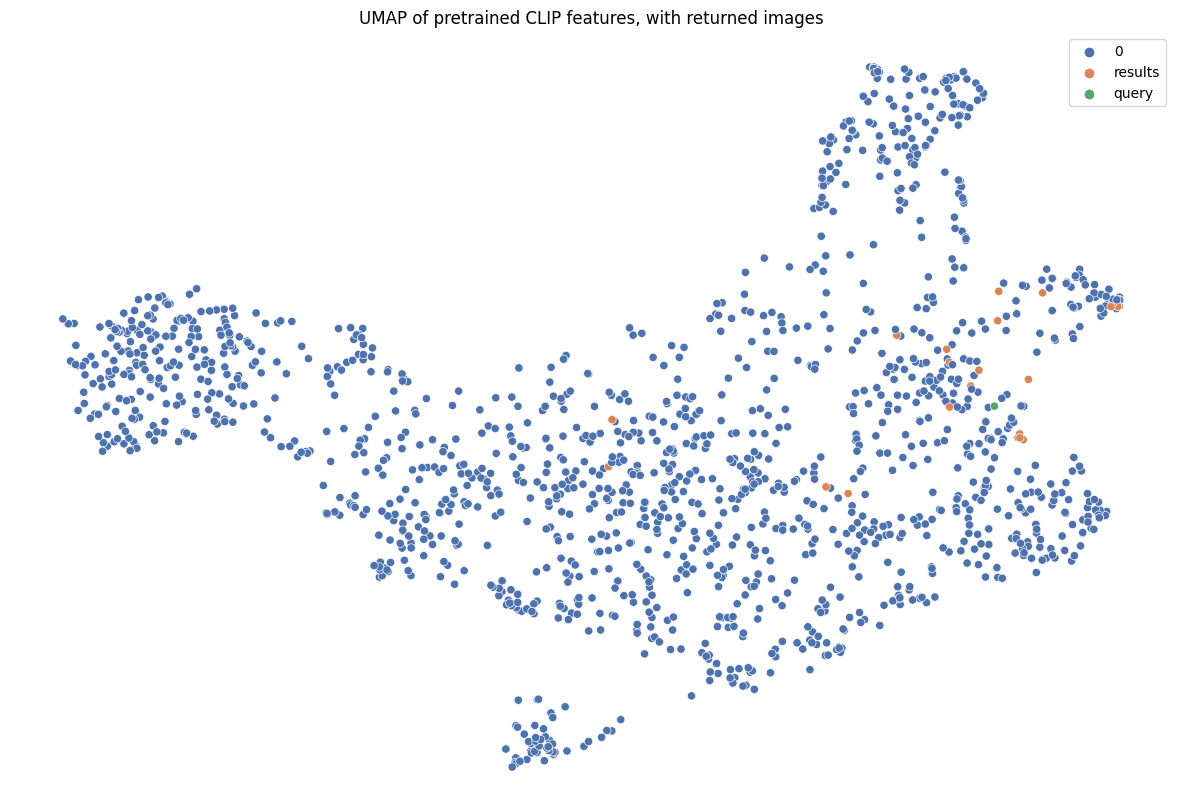

Saved UMAP fig to C:\Users\Yaya Tang\PycharmProjects\clip-smart-search\output\20230810_1200\umap_TACO_returned_20230810_1200.png


<Figure size 640x480 with 0 Axes>

In [59]:
plt.figure(figsize=(15, 10))
sns.scatterplot(x=thumbs_df['x'], y=thumbs_df['y'], hue=np.array(thumbs_df['query_returned']), palette="deep", markers=["o", "*"])
plt.axis('off')
plt.title('UMAP of pretrained CLIP features, with returned images')
plt.show()

plot_filename = f"umap_TACO_returned_{timestamp}.png"
save_path = os.path.join(save_dir, plot_filename)
plt.savefig(save_path, dpi=800)
print(f'Saved UMAP fig to {save_path}')

Saved UMAP fig to C:\Users\Yaya Tang\PycharmProjects\clip-smart-search\output\20230810_1200\umap_TACO_returned_20230810_1200.png


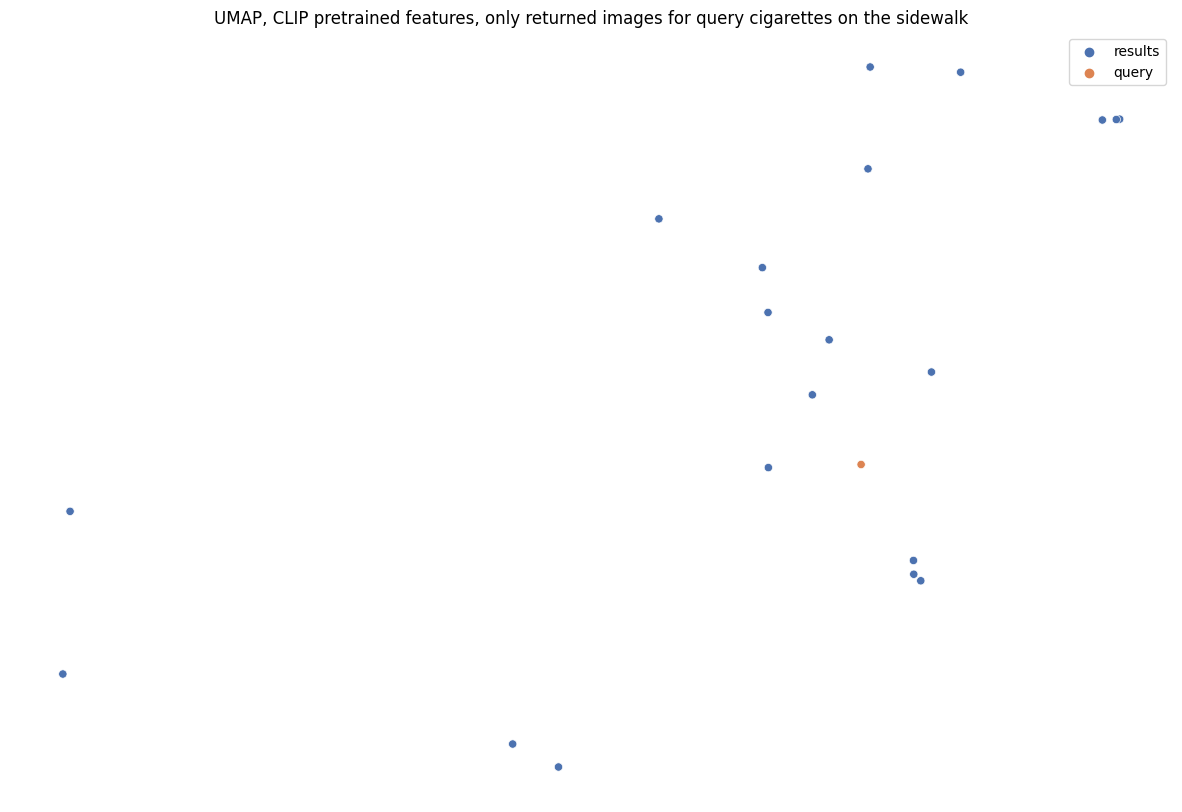

In [60]:
# plot only returned images
df_filt = thumbs_df[thumbs_df['query_returned'] != '0']
plt.figure(figsize=(15, 10))
sns.scatterplot(x=df_filt['x'], y=df_filt['y'], hue=np.array(df_filt['query_returned']), palette="deep")
plt.axis('off')
plt.title(f'UMAP, CLIP pretrained features, only returned images for query {QUERY_STRING}')

plot_filename = f"umap_TACO_returned_{timestamp}.png"
save_path = os.path.join(save_dir, plot_filename)
plt.savefig(save_path, dpi=800)
print(f'Saved UMAP fig to {save_path}')

### Random script for changing plot point markers

In [61]:
# import numpy as np
# import matplotlib.pyplot as plt

# x = np.random.rand(100)
# y = np.random.rand(100)
# category = np.random.randint(0, 3, 100)

# markers = ['s', 'o', 'h', '+']
# for k, m in enumerate(markers):
#     i = (category == k)
#     print(m)
#     plt.scatter(x[i], y[i], marker=m)

# plt.show()

# Interactive visualization

Now plot it using an interactive visualization that shows the images in feature vector space. For example, now you can look at the images closest to the query embedding.


In [ ]:
# ###################
# # interactive viz #
# ###################
# # copied from kaggle nb
# dataset.transform = None
# image_urls = b64_image_files(images_generator(dataset))

# source = ColumnDataSource(data=dict(
#     x=thumbs_df['x'],
#     y=thumbs_df['y'],
#     # label=[str(l) for l in labels],
#     # prediction=[str(p) for p in predictions],
#     # success=[str(s) for s in success],
#     # desc=descs,
#     imgs=img_paths,
#     # image_urls=image_urls,
# ))

# TOOLTIPS = """
#     <div>
#         <div>
#             <img
#                 src="@image_urls" height="200" alt="@image_urls" width="200"
#                 style="float: left; margin: 0px 15px 15px 0px;"
#                 border="2"
#             ></img>
#         </div>
#         <div>
#             <div style="font-size: 15px; font-weight: bold;">Label: @label</div>
#             <div style="font-size: 15px; font-weight: bold;">Predicted: @prediction</div>
#             <div style="font-size: 12px; font-weight: bold;">Success: @success</div>
#             <div style="font-size: 12px;">@desc</div>
#             <div style="font-size: 12px; color: #966;">[$index]</div>
#         </div>
#     </div5
# """

# p = figure(plot_width=1000, plot_height=600, tooltips=TOOLTIPS,
#            title="UMAP: Mouse over the dots")

# mapper = factor_cmap(field_name='label', palette=Category10[5], factors=['0', '1', '2', '3', '4'])

# p.scatter('x', 'y',
#           color=mapper,
#           marker=factor_mark('success', ['circle', 'x'], [str(True), str(False)]),
#           size=10,
#           fill_alpha=0.5,
#           legend_field="desc",
#           source=source)

# p.legend.orientation = "vertical"
# p.legend.location = "top_right"
# output_file("umap.html")
# show(p)

# Fine-tune CLIP on TACO 100

To improve the results, we fine-tune CLIP on 100 images with descriptions and see if the results are better.

In [ ]:
BATCH_SIZE = 32
NUM_EPOCHS = 20
MODEL_VERSION = "1_TACO100"

In [ ]:
def get_data():
    data_pairs = pd.read_csv(r"C:\Users\Yaya Tang\Documents\DATASETS\TACO 100\taco_100_INPUTS_nb.csv")
    return data_pairs['filepath'], data_pairs['img_description']

class image_title_dataset(Dataset):
    def __init__(self, list_image_path, list_txt):
        self.image_path = list_image_path
        # you can tokenize everything at once in here(slow at the beginning), or tokenize it in the training loop.
        self.title = clip.tokenize(list_txt)

    def __len__(self):
        return len(self.title)

    def __getitem__(self, idx):
        image = preprocess(Image.open(self.image_path[idx]))  # Image from PIL module
        title = self.title[idx]
        return image, title

In [ ]:
# load data
random_seed = 11
torch.manual_seed(random_seed)

list_image_path, list_txt = get_data()
dataset = image_title_dataset(list_image_path, list_txt)
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE)

def convert_models_to_fp32(model):
    for p in model.parameters():
        p.data = p.data.float()
        p.grad.data = p.grad.data.float()

In [ ]:
# train model
# if model iteration name already exists, skip and load instead
try:
    checkpoint_path = rf"C:\Users\Yaya Tang\PycharmProjects\clip-smart-search\checkpoints\model_{MODEL_VERSION}_BEST.pt"
    
    model, preprocess = clip.load("ViT-B/32", device=device)  # Must set jit=False for training
    checkpoint = torch.load(checkpoint_path)

    model.load_state_dict(checkpoint['model_state_dict'])
    print(f"Model {MODEL_VERSION} loaded")
except FileNotFoundError:
    if device == "cpu":
        model.float()
    else:
        clip.model.convert_weights(model)  # Actually this line is unnecessary since clip by default already on float16
    
    # keep track of the best model
    EARLY_STOPPING = 10 
    best_loss = np.Inf
    best_iter = 0
    end_training = False
    
    # loss fxns for images and their descriptions
    loss_img = nn.CrossEntropyLoss()
    loss_txt = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=5e-5, betas=(0.9, 0.98), eps=1e-6,
                                 weight_decay=0.2)  # Params used from paper, the lr is smaller, more safe for fine tuning to new dataset
    
    for epoch in range(NUM_EPOCHS):
        pbar = tqdm.tqdm(dataloader, total=len(dataloader))
        for batch in dataloader:
            optimizer.zero_grad()
    
            images, texts = batch
            images = images.to(device)
            texts = texts.to(device)
    
            # forward pass
            logits_per_image, logits_per_text = model(images, texts)
    
            # calc loss + backprop
            ground_truth = torch.arange(len(images), dtype=torch.long, device=device)
            total_loss = (loss_img(logits_per_image, ground_truth) + loss_txt(logits_per_text, ground_truth)) / 2
            total_loss.backward()
            if device == "cpu":
                optimizer.step()
            else:
                convert_models_to_fp32(model)
                optimizer.step()
                clip.model.convert_weights(model)
    
            pbar.set_description(f"Epoch {epoch + 1}/{NUM_EPOCHS}, Loss: {total_loss.item():.4f}")
        pbar.update()
        
        
        if epoch == 0:
            best_loss = total_loss # val_loss
        elif total_loss < best_loss: # val_loss < best_loss:
            best_iter = epoch + 1
            best_loss = total_loss # val_loss
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': total_loss,  # val_loss,
            }, rf"C:\Users\Yaya Tang\PycharmProjects\clip-smart-search\checkpoints\model_{MODEL_VERSION}_BEST.pt")
    
        if ((epoch + 1) - best_iter) > EARLY_STOPPING:
            print("Early stop achieved at", epoch + 1)
            break
        
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': total_loss,
        }, rf"C:\Users\Yaya Tang\PycharmProjects\clip-smart-search\checkpoints\model_{MODEL_VERSION}_epoch_{epoch + 1}.pt")


### Re-create image embeddings

In [ ]:
# create image features
model = model.eval()
image_input = torch.tensor(np.stack(images_np)).to(device)
with torch.no_grad():
    image_features = model.encode_image(image_input)

image_features /= image_features.norm(dim=-1, keepdim=True)

### Query images with fine-tuned CLIP

We can now take the images that were returned and color them in on the UMAP plot:

In [ ]:
# create query feature
QUERY_STRING = "cigarettes on the sidewalk"
query_keyword = "cigarette"
NUM_RESULTS = 20

text_tokens = clip.tokenize([QUERY_STRING]).to(device)
with torch.no_grad():
    text_features = model.encode_text(text_tokens)
text_features /= text_features.norm(dim=-1, keepdim=True)

## Get the K nearest images to the query

In [ ]:
# get top results
results = cosine_similarity(text_features.cpu().numpy(), image_features.cpu().numpy())

results_dict = {'name': [], 'prob': [], 'filepath': []}

# reset img_paths from the last use
img_paths = orig_img_paths.copy()
pbar = tqdm.tqdm(total=len(img_paths))
for i, img_path in enumerate(img_paths):
    results_dict['name'].append(Path(img_path).name)
    results_dict['prob'].append(results[0][i])
    results_dict['filepath'].append(img_path)
    results_dict.update()
    pbar.update()

results_df = pd.DataFrame(results_dict)
results_df.sort_values(by=['prob'], ascending=False, inplace=True)

results_df = results_df.iloc[:NUM_RESULTS][['name', 'prob', 'filepath']]

results_with_labels = results_df[['name', 'prob']]
results_with_labels['labels'] = [item_labels_lookup[name] for name in results_df['name']]
results_with_labels['has_keyword'] = [1 if query_keyword in [item.lower() for item in result] else 0 for result in results_with_labels['labels']]
results_with_labels.to_csv(Path(save_dir, f'finetuned_results_{MODEL_VERSION}_{timestamp}.csv'))

print(results_with_labels[['name', 'prob']]) #, 'labels']])

# show the number of images with labels that include the keyword
num_hits = sum(results_with_labels['has_keyword'])
print(f'Number of images that have the keyword in the labels: {num_hits}')

## Plot returned images from query


In [ ]:
# plot returned images on a grid
num_grid = math.isqrt(NUM_RESULTS)
subplot_dims = num_grid + 1 if num_grid ** 2 < NUM_RESULTS else num_grid

plt.figure(figsize=(20, 20))
plt.tight_layout()
for i, img_path in enumerate(results_df['filepath'].iloc[:NUM_RESULTS]):
    plt.subplot(subplot_dims, subplot_dims, i + 1)
    image = Image.open(img_path).convert("RGB")
    plt.text(0,-1, f'{Path(img_path).name}', verticalalignment="bottom", wrap=True)
    plt.text(0,0, f'{item_labels_lookup[Path(img_path).name]}', verticalalignment="top", wrap=True)
    plt.imshow(image)

plt.suptitle(f"Query: '{QUERY_STRING}', returned {len(results_df)}, on fine-tuned CLIP {MODEL_VERSION}\nfound {num_hits}")
plot_filename = f"clip_query_results_{MODEL_VERSION}_{timestamp}.png"
save_path = os.path.join(save_dir, plot_filename)
plt.savefig(save_path, dpi=800)
print(f'Saved query results to {save_path}')

## Visualize: dim reduction of fine-tuned features

For UMAP dimension reduction, we can take the image features (n_images, 512) to (n_images, 2)


In [ ]:
####################################
# UMAP reduction and visualization #
####################################
# concatenate both image + query features and reduce with UMAP
all_features = torch.cat((image_features, text_features), 0)
reducer = umap.UMAP(random_state=42, metric='cosine')
embedding = reducer.fit_transform(all_features.cpu())

# update lists to include the query string as the last item
names = [Path(path).name for path in img_paths]
results = results_df['name'].tolist()
query_returned = ['results' if name in results else '0' for name in names]

names.append('query')
query_returned.append('query')
img_paths.append('query')

thumbs_df = pd.DataFrame(embedding, columns=['x', 'y'])
thumbs_df['filename'] = img_paths
thumbs_df['name'] = names
thumbs_df['query_returned'] = query_returned

In [ ]:
plt.figure(figsize=(15, 10))
sns.scatterplot(x=thumbs_df['x'], y=thumbs_df['y'], hue=np.array(thumbs_df['query_returned']), palette="deep")
plt.axis('off')
plt.title(f'UMAP of fine-tuned CLIP features, with returned images for model {MODEL_VERSION}')
plt.show()

plot_filename = f"UMAP_clip_query_results_{MODEL_VERSION}_{timestamp}.png"
save_path = os.path.join(save_dir, plot_filename)
plt.savefig(save_path, dpi=800)
print(f'Saved query results to {save_path}')